In [10]:
#data manipulation
from pathlib import Path
import numpy as np
from numpy import percentile
from datetime import datetime, timedelta
import xarray as xr
from netCDF4 import Dataset
import pandas as pd
import glob
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor

from math import sqrt
import scipy.stats

#double iteration in pandas
from itertools import product

#compute distance between two points on earth
from haversine import haversine, haversine_vector, Unit

#mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import gdal

#colorbars
import cmocean
import cmaps

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatch
import matplotlib.patches as patches
from matplotlib.transforms import offset_copy
import matplotlib.colors as colors
import seaborn as seabornInstance 
from windrose import WindroseAxes
import seaborn as sns; sns.set(color_codes=True)
#from matplotlib import style
#style.use('fivethirtyeight')

%matplotlib inline

# Cryosat 2 (2014-)

### 1 Hz

In [129]:
# function to remove outliers from every single along track

def remove_outliers(fname):
    
    #read the data files
    df2 = xr.open_dataset(fname, drop_variables=['alt_20_plrm_ku','flag_instr_op_mode_20_plrm_ku','ind_meas_1hz_20_plrm_ku','lat_20_plrm_ku',
                                                 'lon_20_plrm_ku','mqe_ocean_20_plrm_ku','peakiness_20_plrm_ku','qual_ssha_20_plrm_ku',
                                                 'range_ocean_20_plrm_ku','range_ocean_qual_20_plrm_ku','range_ocog_20_plrm_ku',
                                                 'range_ocog_qual_20_plrm_ku','retracking_ocean_qual_20_plrm_ku','scale_factor_20_plrm_ku',
                                                 'sig0_ocean_20_plrm_ku','sig0_ocean_qual_20_plrm_ku','sig0_ocog_20_plrm_ku',
                                                 'sig0_ocog_qual_20_plrm_ku','ssha_20_plrm_ku','swh_ocean_20_plrm_ku',
                                                 'swh_ocean_qual_20_plrm_ku','time_1hz_20_plrm_ku','time_20_plrm_ku'])
    
    #select all the required variables to detect only the valid data
    df2 = df2[['swh_ocean_01_ku','surf_type_01','sig0_ocean_01_ku','wind_speed_alt_01_ku','sig0_ocean_rms_01_ku','swh_ocean_rms_01_ku', \
               'range_ocean_rms_01_ku','swh_ocean_numval_01_ku']]
    
    # convert to pandas dataframe
    df2 = df2.to_dataframe()
    df2.reset_index(inplace=True)
    
        # apply the filtering criteria
    df2 = df2[(df2['swh_ocean_01_ku'] <= 30.) & (df2['swh_ocean_01_ku'] >= 0.) & (df2['surf_type_01'] == 0.) \
              & (df2['sig0_ocean_01_ku'] <= 30.) & (df2['sig0_ocean_01_ku'] >= 2.8) \
              & (df2['wind_speed_alt_01_ku'] <= 30.) & (df2['wind_speed_alt_01_ku'] >= 0.) & (df2['sig0_ocean_rms_01_ku'] <= 1.) \
              & (df2['sig0_ocean_rms_01_ku'] >= 0.) & (df2['range_ocean_rms_01_ku'] >= 0) \
              & (df2['range_ocean_rms_01_ku'] <= (0.014*df2['swh_ocean_01_ku'] + 0.25)) \
              & (df2['swh_ocean_numval_01_ku'] >= 10.) & (df2['swh_ocean_rms_01_ku'] < df2['swh_ocean_01_ku'])]
    
    outliers_removed = df2
    
    
    # remove outliers from significant wave height
    q1 = df2['swh_ocean_01_ku'].quantile(0.25)
    q3 = df2['swh_ocean_01_ku'].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    
    outliers_removed = df2.loc[(df2['swh_ocean_01_ku'] > fence_low) & (df2['swh_ocean_01_ku'] < fence_high)]
    
    """

    #use the standard deviation method
    
    # calculate summary statistics
    data_mean, data_std = np.mean(df2['swh']), np.std(df2['swh'])
    #identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    # remove outliers
    outliers_removed = df2.loc[(df2['swh'] > lower) & (df2['swh'] < upper)]
    
    
    
    #remove outliers from wind speed
    q1 = df2['wind_speed_alt'].quantile(0.25)
    q3 = df2['wind_speed_alt'].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    outliers_removed = df2.loc[(df2['wind_speed_alt'] > fence_low) & (df2['wind_speed_alt'] < fence_high)]
    
    """

    return outliers_removed

In [130]:
test2 = xr.open_dataset('C:/Users/panmits86/Desktop/Python/data/Cryosat2/CS_LTA__SIR_GOPM_2_20140108T142639_20140108T143817_C001.nc', \
               drop_variables=['alt_20_plrm_ku','flag_instr_op_mode_20_plrm_ku','ind_meas_1hz_20_plrm_ku','lat_20_plrm_ku','lon_20_plrm_ku',
                              'mqe_ocean_20_plrm_ku','peakiness_20_plrm_ku','qual_ssha_20_plrm_ku','range_ocean_20_plrm_ku',
                              'range_ocean_qual_20_plrm_ku','range_ocog_20_plrm_ku','range_ocog_qual_20_plrm_ku',
                               'retracking_ocean_qual_20_plrm_ku','scale_factor_20_plrm_ku','sig0_ocean_20_plrm_ku',
                               'sig0_ocean_qual_20_plrm_ku','sig0_ocog_20_plrm_ku','sig0_ocog_qual_20_plrm_ku','ssha_20_plrm_ku',
                              'swh_ocean_20_plrm_ku','swh_ocean_qual_20_plrm_ku','time_1hz_20_plrm_ku','time_20_plrm_ku'])

In [131]:
# import all data files
p = Path('C:/Users/panmits86/Desktop/Python/data/Cryosat2')
#p = Path('C:/Users/panmits86/Desktop/SA_GDR')
#p = Path('C:/Users/panmits86/masters_thesis/data/satellite/SARAL-AltiKa/IGDR/2014_Q4')
# iterate the process to every data file
results = []
for fname in p.glob('*.nc'):
    swh_cr = remove_outliers(fname)
    results.append(swh_cr)
    swh_c2 = pd.concat(results)

In [132]:
swh_cr = swh_c2[['time_01','lon_01','lat_01','swh_ocean_01_ku','wind_speed_alt_01_ku']]
swh_cr = swh_cr.reset_index()
swh_cr.drop(['index'], axis=1, inplace=True)
swh_cr

,time_01,lon_01,lat_01,swh_ocean_01_ku,wind_speed_alt_01_ku
0,2014-01-08 14:28:41.890272000,-67.133838,10.626016,1.959,7.255000
1,2014-01-08 14:28:43.777146048,-67.145908,10.740801,1.404,6.749001
2,2014-01-08 14:28:44.720583040,-67.151944,10.798193,1.523,6.418000
3,2014-01-08 14:28:45.664020032,-67.157981,10.855585,1.687,6.017000
4,2014-01-08 14:28:46.607457024,-67.164019,10.912976,1.497,5.662000
...,...,...,...,...,...
296693,2020-04-28 20:42:31.540694016,-73.911854,39.958472,0.838,5.625000
296694,2020-04-28 20:42:32.484130944,-73.919228,40.015693,0.907,5.354000
296695,2020-04-28 20:42:33.427566976,-73.926608,40.072913,0.807,5.257000
296696,2020-04-28 20:42:34.371004032,-73.933993,40.130132,0.753,5.102000


In [133]:
buoys = pd.read_excel('buoys.xlsx', header=0, index_col=None, usecols="C:E")
buoys

,Buoys,Longitude,Latitude
0,44097,-71.127,40.969
1,44020,-70.279,41.493
2,44025,-73.164,40.251
3,44017,-72.049,40.693
4,44065,-73.703,40.369
5,44039,-72.655,41.138
6,44040,-73.580,40.956
7,BUZM3,-71.033,41.397


In [134]:
for x,y,z in zip(buoys['Longitude'], buoys['Latitude'], buoys['Buoys']):print(x,y,z)

-71.127 40.969 44097
-70.279 41.493 44020
-73.164 40.251 44025
-72.049 40.693 44017
-73.703 40.369 44065
-72.655 41.138 44039
-73.58 40.956 44040
-71.033 41.397 BUZM3


In [135]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(15, 20),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlabels_top = False
    gl.xlocator = mticker.FixedLocator([-74, -73, -72, -71, -70])
    gl.ylocator = mticker.FixedLocator([40, 41, 42])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

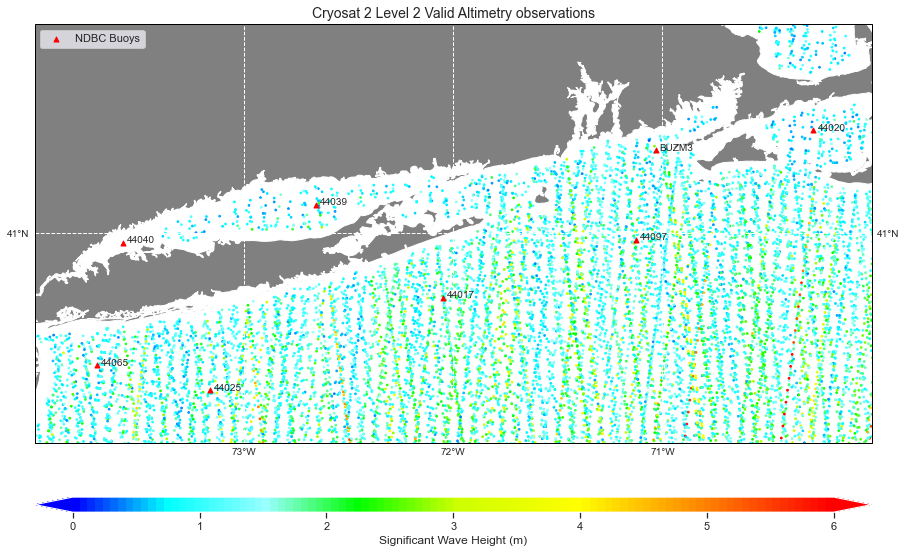

In [136]:
# Map of Wave Height observations

fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-74, -70, 40, 42])

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_f_L1_SNE.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')

#cmap=cmaps.GMT_seis_r
cmap=cmaps.BlAqGrYeOrRe
bounds = np.array([0,1,2,3,4,5,6])
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=12)
norm = mpl.colors.Normalize(vmin=0, vmax=6)
cs2 = plt.scatter(swh_cr['lon_01'], swh_cr['lat_01'], c=swh_cr['swh_ocean_01_ku'], s=3, marker='o', cmap=cmap, norm=norm,
            transform=ccrs.Geodetic())
cax,kw = mpl.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)
out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('Significant Wave Height (m)',size=12)
ax.set_title('Cryosat 2 Level 2 Valid Altimetry observations',size=14)


ax.scatter(buoys['Longitude'], buoys['Latitude'], s=25, marker='^', color='red', label='NDBC Buoys',transform=ccrs.Geodetic())

for x,y,z in zip(buoys['Longitude'], buoys['Latitude'], buoys['Buoys']):
    ax.text(x+0.02, y+0.01, z,
                 verticalalignment='center', horizontalalignment='left', fontsize=10,
                 transform=ccrs.Geodetic())

    ax.legend(loc='upper left')

plt.savefig('SNE_obs_C2_wh_valid.png', dpi=300, bbox_inches='tight')

In [137]:
buoys = pd.read_excel('buoys.xlsx', header=0, index_col=None, usecols="D:E")

In [138]:
# coordinates of buoy 44017
b44017 = (buoys['Latitude'][3],buoys['Longitude'][3]+360)
b44017

(40.693, 287.951)

In [139]:
# make a parser to include minutes, hours, days, months, years in one column and convert to datetime
def parse(yr, mo, doy, hr, min):
    yr, mo, doy, hr, min = [int(x) for x in [yr, mo, doy, hr, min]]
    dt = datetime(yr - 0, mo, doy, hr, min)
    return dt

In [140]:
#read all files since 2016 for the 44097 buoy and concatenate them into one single pandas data frame and exclude wave height error values
path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44017_1'
all_files = glob.glob(path + "/*.txt")

b44017_wind_wave = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44017_wind_wave = b44017_wind_wave[(b44017_wind_wave.WVHT !=99) & (b44017_wind_wave.WVHT > 0.0) &
                                   (b44017_wind_wave.WSPD !=99) & (b44017_wind_wave.WSPD > 0.0)]
b44017_wind_wave.reset_index(inplace=True)
b44017_wind_wave.drop('index', 1, inplace=True)
#b44017_wind_wave['u10'] = b44017_wind_wave['WSPD']*(10/4.1)**0.11
b44017_wind_wave['u10'] = b44017_wind_wave['WSPD']*np.sqrt((0.4**2)/0.0014)*(1/(np.log(4.1/0.000097)))
b44017_wind_wave

,Date,WSPD,WVHT,u10
0,2013-12-31 23:50:00,13.6,1.81,13.649364
1,2014-01-01 00:50:00,13.0,1.94,13.047187
2,2014-01-01 01:50:00,11.7,1.96,11.742468
3,2014-01-01 02:50:00,11.0,1.97,11.039927
4,2014-01-01 03:50:00,11.5,1.86,11.541742
...,...,...,...,...
31346,2019-08-23 06:40:00,3.9,1.37,3.914156
31347,2019-08-23 07:40:00,4.0,1.36,4.014519
31348,2019-08-23 08:40:00,4.6,1.38,4.616697
31349,2019-08-23 09:40:00,3.5,1.31,3.512704


In [141]:
b44017_time = b44017_wind_wave['Date']
b44017_time

0       2013-12-31 23:50:00
1       2014-01-01 00:50:00
2       2014-01-01 01:50:00
3       2014-01-01 02:50:00
4       2014-01-01 03:50:00
                ...        
31346   2019-08-23 06:40:00
31347   2019-08-23 07:40:00
31348   2019-08-23 08:40:00
31349   2019-08-23 09:40:00
31350   2019-08-23 10:40:00
Name: Date, Length: 31351, dtype: datetime64[ns]

In [142]:
a1 = [(swh_cr['lat_01'][n], swh_cr['lon_01'][n]) for n in range(swh_cr.shape[0])]

In [143]:
# compute the distance between each SARAL-AltiKa datapoint and the position of buoy 44017
hav5 = haversine_vector([b44017]*swh_cr.shape[0],a1, Unit.KILOMETERS)
coloc = pd.DataFrame(hav5, columns=['Buoy-Sat. Distance (km)'])
coloc

,Buoy-Sat. Distance (km)
0,3377.985448
1,3365.158302
2,3358.744789
3,3352.331315
4,3345.917890
...,...
296693,177.784690
296694,175.457059
296695,173.333567
296696,171.421788


In [144]:
swh_cr['Buoy-Sat. Distance (km)'] = coloc
swh_cr

,time_01,lon_01,lat_01,swh_ocean_01_ku,wind_speed_alt_01_ku,Buoy-Sat. Distance (km)
0,2014-01-08 14:28:41.890272000,-67.133838,10.626016,1.959,7.255000,3377.985448
1,2014-01-08 14:28:43.777146048,-67.145908,10.740801,1.404,6.749001,3365.158302
2,2014-01-08 14:28:44.720583040,-67.151944,10.798193,1.523,6.418000,3358.744789
3,2014-01-08 14:28:45.664020032,-67.157981,10.855585,1.687,6.017000,3352.331315
4,2014-01-08 14:28:46.607457024,-67.164019,10.912976,1.497,5.662000,3345.917890
...,...,...,...,...,...,...
296693,2020-04-28 20:42:31.540694016,-73.911854,39.958472,0.838,5.625000,177.784690
296694,2020-04-28 20:42:32.484130944,-73.919228,40.015693,0.907,5.354000,175.457059
296695,2020-04-28 20:42:33.427566976,-73.926608,40.072913,0.807,5.257000,173.333567
296696,2020-04-28 20:42:34.371004032,-73.933993,40.130132,0.753,5.102000,171.421788


In [145]:
# keep satellite observations in a radius of 0.25 degrees relative to the buoy
#dist = pd.DataFrame(hav5, columns=['Buoy-Sat. Distance (km)'])
radius = swh_cr['Buoy-Sat. Distance (km)'] < 15
colocated = swh_cr[radius]
colocated.reset_index(inplace=True)
colocated.drop('index', 1, inplace=True)
colocated

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,time_01,lon_01,lat_01,swh_ocean_01_ku,wind_speed_alt_01_ku,Buoy-Sat. Distance (km)
0,2014-03-09 11:44:33.809340032,-71.964026,40.621840,1.378,7.304000,10.676648
1,2014-03-09 11:44:34.752776960,-71.971461,40.679042,1.363,6.814000,6.719686
2,2014-03-09 11:44:35.696214016,-71.978902,40.736243,1.219,6.409000,7.617448
3,2014-03-09 11:44:36.639651008,-71.986350,40.793444,1.239,6.217000,12.353224
4,2014-03-15 23:38:58.632195968,-71.933710,40.780409,2.140,5.682000,13.741259
...,...,...,...,...,...,...
212,2020-03-26 22:12:37.796086016,-71.998101,40.806427,1.902,6.033000,13.321391
213,2020-04-02 10:06:58.845193088,-71.937148,40.797341,1.596,11.065001,14.946564
214,2020-04-02 10:06:59.788630016,-71.944596,40.740133,1.525,11.239000,10.241705
215,2020-04-02 10:07:00.732066944,-71.952037,40.682924,1.771,11.548000,8.251958


In [146]:
sat_time = colocated['time_01'].reset_index()
sat_time.drop('index', 1, inplace=True)
sat_time['time_01']

0     2014-03-09 11:44:33.809340032
1     2014-03-09 11:44:34.752776960
2     2014-03-09 11:44:35.696214016
3     2014-03-09 11:44:36.639651008
4     2014-03-15 23:38:58.632195968
                   ...             
212   2020-03-26 22:12:37.796086016
213   2020-04-02 10:06:58.845193088
214   2020-04-02 10:06:59.788630016
215   2020-04-02 10:07:00.732066944
216   2020-04-02 10:07:01.675504000
Name: time_01, Length: 217, dtype: datetime64[ns]

In [147]:
#time difference in minutes
diff = [(b44017_time[d], b44017_wind_wave['WVHT'][d], b44017_wind_wave['u10'][d], sat_time['time_01'][s], colocated['swh_ocean_01_ku'][s], \
         colocated['wind_speed_alt_01_ku'][s], colocated['Buoy-Sat. Distance (km)'][s],
         (sat_time['time_01'][s] - b44017_time[d]).total_seconds() / 60) for d, s in product(range(b44017_time.shape[0]), range(sat_time.shape[0]))]

In [148]:
t = pd.DataFrame(list(diff))
t.columns = ['Buoy 44017 Time', 'Buoy 44017 Wave Height', 'Buoy 44017 U10', 'Cryosat 2 Time', 'Cryosat 2 Wave Height', \
             'Cryosat 2 Wind Speed', 'Buoy-Sat. Distance (km)', 'Time Difference (min.)']

In [2]:
final1 = pd.read_csv('C:/Users/panmits86/Desktop/Python/b44017_SARAL_15km_radius_dcd2.txt',  sep='\t')
final1

,Buoy 44017 Time,Buoy 44017 Wave Height,Buoy 44017 U10,SARAL-AltiKa Time,SARAL-AltiKa Wave Height,SARAL-AltiKa Wind Speed,Buoy-Sat. Distance (km),Time Difference (min.)
0,2015-05-25 23:50:00.000000000,0.78,9.133031,2015-05-25 23:21:37.495393024,0.982,7.59,10.457612,-28.375077
1,2015-06-29 23:50:00.000000000,1.58,7.527223,2015-06-29 23:21:22.727104896,1.616,6.70,14.021561,-28.621215
2,2015-06-29 23:50:00.000000000,1.58,7.527223,2015-06-29 23:21:23.765152000,1.573,6.27,7.862886,-28.603914
3,2015-06-29 23:50:00.000000000,1.58,7.527223,2015-06-29 23:21:25.841248960,1.571,6.13,9.194974,-28.569313
4,2015-07-26 10:50:00.000000000,0.62,4.717060,2015-07-26 10:21:19.420824064,0.703,4.67,14.912536,-28.676320
...,...,...,...,...,...,...,...,...
88,2019-07-07 23:40:00.000000000,0.92,5.118512,2019-07-07 23:15:02.653878272,1.054,5.27,10.782910,-24.955769
89,2019-08-16 10:40:00.000000000,1.17,4.817423,2019-08-16 10:15:34.246190976,1.035,4.62,14.076947,-24.429230
90,2019-08-16 10:40:00.000000000,1.17,4.817423,2019-08-16 10:15:35.283711872,1.156,5.11,7.862519,-24.411938
91,2019-08-16 10:40:00.000000000,1.17,4.817423,2019-08-16 10:15:36.321230848,1.166,5.14,4.777554,-24.394646


In [149]:
final = abs(t['Time Difference (min.)']) < 30.
final = t[final]
final

,Buoy 44017 Time,Buoy 44017 Wave Height,Buoy 44017 U10,Cryosat 2 Time,Cryosat 2 Wave Height,Cryosat 2 Wind Speed,Buoy-Sat. Distance (km),Time Difference (min.)
346983,2014-03-09 11:50:00,1.26,9.133031,2014-03-09 11:44:33.809340032,1.378,7.304,10.676648,-5.436511
346984,2014-03-09 11:50:00,1.26,9.133031,2014-03-09 11:44:34.752776960,1.363,6.814,6.719686,-5.420787
346985,2014-03-09 11:50:00,1.26,9.133031,2014-03-09 11:44:35.696214016,1.219,6.409,7.617448,-5.405063
346986,2014-03-09 11:50:00,1.26,9.133031,2014-03-09 11:44:36.639651008,1.239,6.217,12.353224,-5.389339
380188,2014-03-15 23:50:00,2.15,4.817423,2014-03-15 23:38:58.632195968,2.140,5.682,13.741259,-11.022797
...,...,...,...,...,...,...,...,...
6541428,2019-06-17 12:40:00,1.13,1.304719,2019-06-17 12:15:09.888973056,1.282,3.637,13.105906,-24.835184
6541429,2019-06-17 12:40:00,1.13,1.304719,2019-06-17 12:15:10.832409984,1.197,3.278,12.745189,-24.819460
6642340,2019-07-22 22:40:00,0.68,3.412341,2019-07-22 22:44:32.401309952,0.628,2.109,11.439506,4.540022
6642341,2019-07-22 22:40:00,0.68,3.412341,2019-07-22 22:44:33.344747008,0.394,2.410,10.009494,4.555746


In [150]:
final.to_csv('b44017_Cryosat2_15km_radius_dcd2_qc.txt', sep='\t', index=False)

In [151]:
final1 = final.set_index('Buoy 44017 Time')
final1

,Buoy 44017 Wave Height,Buoy 44017 U10,Cryosat 2 Time,Cryosat 2 Wave Height,Cryosat 2 Wind Speed,Buoy-Sat. Distance (km),Time Difference (min.)
Buoy 44017 Time,,,,,,,
2014-03-09 11:50:00,1.26,9.133031,2014-03-09 11:44:33.809340032,1.378,7.304,10.676648,-5.436511
2014-03-09 11:50:00,1.26,9.133031,2014-03-09 11:44:34.752776960,1.363,6.814,6.719686,-5.420787
2014-03-09 11:50:00,1.26,9.133031,2014-03-09 11:44:35.696214016,1.219,6.409,7.617448,-5.405063
2014-03-09 11:50:00,1.26,9.133031,2014-03-09 11:44:36.639651008,1.239,6.217,12.353224,-5.389339
2014-03-15 23:50:00,2.15,4.817423,2014-03-15 23:38:58.632195968,2.140,5.682,13.741259,-11.022797
...,...,...,...,...,...,...,...
2019-06-17 12:40:00,1.13,1.304719,2019-06-17 12:15:09.888973056,1.282,3.637,13.105906,-24.835184
2019-06-17 12:40:00,1.13,1.304719,2019-06-17 12:15:10.832409984,1.197,3.278,12.745189,-24.819460
2019-07-22 22:40:00,0.68,3.412341,2019-07-22 22:44:32.401309952,0.628,2.109,11.439506,4.540022


### 0.25 degree Radius

In [895]:
final1.index = pd.to_datetime(final1.index)

In [896]:
df = final1.iloc[:,[0,1,3,4]]
#df1.reset_index(inplace=True)
#df1.drop('index', 1, inplace=True)
df = df.resample('D').mean()
df = df.dropna()
len(df)

61

In [897]:
x = df['Buoy 44017 U10']
y = df['Buoy 44017 Wave Height']

xx = df['SARAL-AltiKa Wind Speed']
yy = df['SARAL-AltiKa Wave Height']

In [898]:
model = LinearRegression(fit_intercept=False)

model.fit(x[:, np.newaxis], xx)

x1fit = np.linspace(0, 17, 61)
y1fit = model.predict(x1fit[:, np.newaxis])

predictions['lower'] = lower_model.predict

print("Model slope:", model.coef_[0])

Model slope: 0.916273707640799


In [899]:
# model line slope
model.coef_

array([0.91627371])

In [900]:
scores_mean = list()
scores_std = list()

scores = cross_validate(model, x[:, np.newaxis], xx, scoring=['r2', 'neg_root_mean_squared_error'], cv=15)

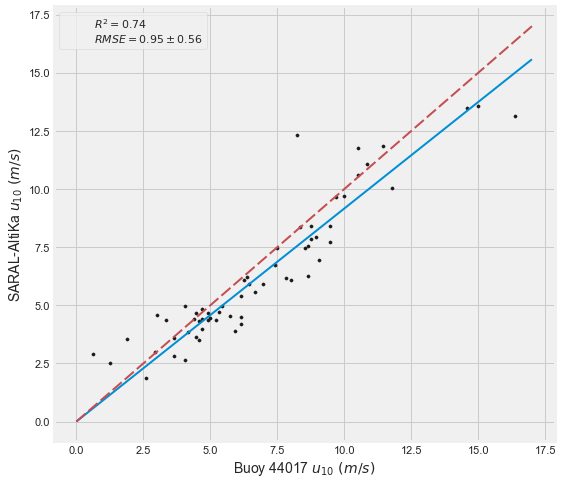

In [901]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(x, xx, s=10, color='k', label='data')
plt.plot(x1fit, y1fit, linewidth=2, label='fitted')
plt.plot([0, 17], [0, 17], dashes=[6, 2], linewidth=2, color='r', label='1-1 line')

plt.xlabel('Buoy 44017 $u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('SARAL-AltiKa $u_{10} \ (m/s)$', fontsize=14)

extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False, edgecolor='none', linewidth=0)
ax.legend([extra], [(r'$R^2={:.2f}$' + '\n' + r'$RMSE={:.2f} \pm {:.2f}$').format(np.mean(scores['test_r2']),
                                                      -np.mean(scores['test_neg_root_mean_squared_error']),
                                                      np.std(scores['test_neg_root_mean_squared_error']))], loc='upper left')

In [902]:
model = LinearRegression(fit_intercept=False)

model.fit(y[:, np.newaxis], yy)

x2fit = np.linspace(0, 4, 1000)
y2fit = model.predict(x2fit[:, np.newaxis])

print("Model slope:", model.coef_)
#print("Model intercept:", model.intercept_)

Model slope: [1.01055822]


In [903]:
scores_mean = list()
scores_std = list()

scores = cross_validate(model, y[:, np.newaxis], yy, scoring=['r2', 'neg_root_mean_squared_error'], cv=15)

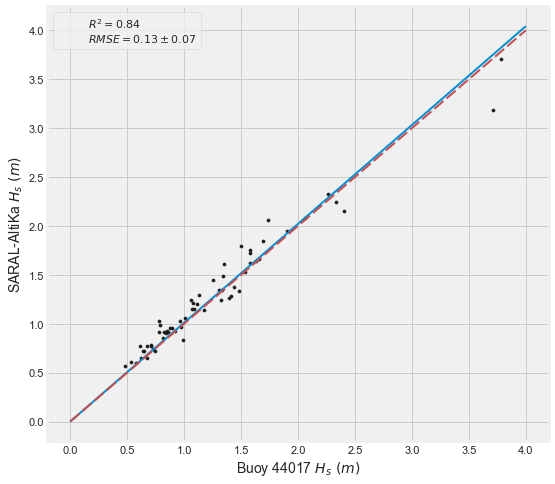

In [904]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(y, yy, s=10, color='k', label='data')
plt.plot(x2fit, y2fit, linewidth=2, label='fitted')
plt.plot([0, 4], [0, 4], dashes=[6, 2], linewidth=2, color='r', label='1-1 line')

plt.xlabel('Buoy 44017 $H_{s} \ (m)$', fontsize=14)
plt.ylabel('SARAL-AltiKa $H_{s} \ (m)$', fontsize=14)

extra = plt.Rectangle((2, 2), 1, 1, facecolor="black", alpha=0, fill=False)
ax.legend([extra], [(r'$R^2={:.2f}$' + '\n' + r'$RMSE={:.2f} \pm {:.2f}$').format(np.mean(scores['test_r2']),
                                                      -np.mean(scores['test_neg_root_mean_squared_error']),
                                                      np.std(scores['test_neg_root_mean_squared_error']))], loc='upper left')
#ax.legend(loc='best')

In [834]:
model1 = LinearRegression(fit_intercept=False)

#model.fit(x[:, np.newaxis], y)
xfit = np.linspace(0, 18, 1000)

poly_model = make_pipeline(PolynomialFeatures(2), model1)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

In [835]:
# model / line coefficients
poly_model.steps[1][1].coef_

array([ 0.99474621, -0.09040481,  0.01526585])

In [836]:
scores_mean = list()
scores_std = list()

scores = cross_validate(poly_model, x[:, np.newaxis], y, scoring=['r2', 'neg_root_mean_squared_error'], cv=15)

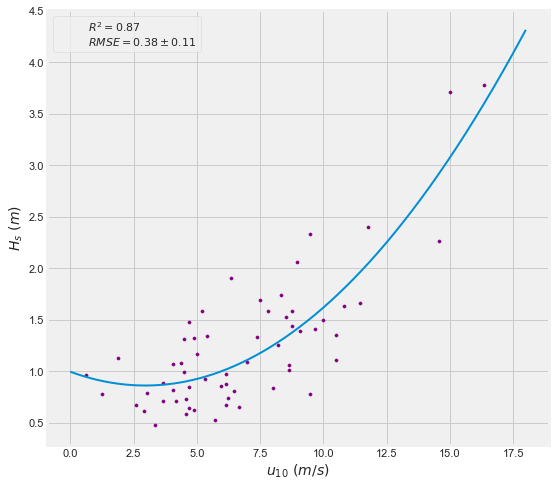

In [837]:
# plot time series of wave height and save figure
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, s=10,color='purple', label='Buoy 44017 data')

ax.plot(xfit, yfit, linewidth=2, label='Buoy 44017')

plt.xlabel('$u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('$H_{s} \ (m)$', fontsize=14)

#ax.set(xlabel="$u_{10} \ (m/s)$",
 #      ylabel="Significant Wave Height (m)")
#ax.legend(loc='best')
extra = plt.Rectangle((2, 2), 1, 1, facecolor="black", alpha=0, fill=False)
ax.legend([extra], [(r'$R^2={:.2f}$' + '\n' + r'$RMSE={:.2f} \pm {:.2f}$').format(-np.mean(scores['test_r2']),
                                                      -np.mean(scores['test_neg_root_mean_squared_error']),
                                                      np.std(scores['test_neg_root_mean_squared_error']))], loc='upper left')

In [842]:
model2 = LinearRegression(fit_intercept=False)

#model.fit(xx[:, np.newaxis], yy)
xxfit = np.linspace(0, 18, 1000)

poly_model1 = make_pipeline(PolynomialFeatures(2), model2)

poly_model1.fit(xx[:, np.newaxis], yy)
yyfit = poly_model1.predict(xxfit[:, np.newaxis])

In [843]:
poly_model1.steps[1][1].coef_

array([0.76160419, 0.01674942, 0.00870768])

In [844]:
scores_mean = list()
scores_std = list()

scores = cross_validate(poly_model1, xx[:, np.newaxis], yy, scoring=['r2', 'neg_root_mean_squared_error'], cv=15)

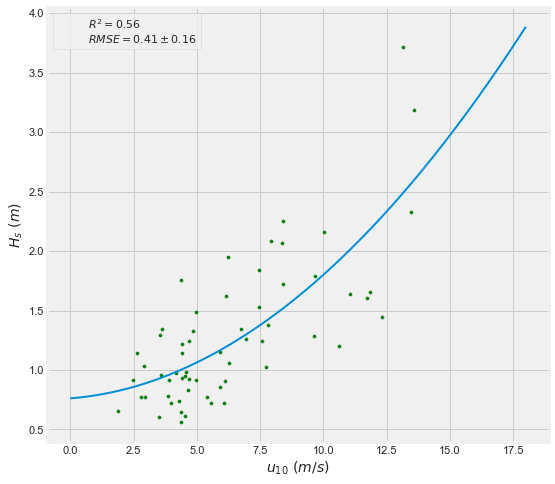

In [845]:
# plot time series of wave height and save figure
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(xx, yy, s=10, color='green', label='SARAL-AltiKa data')
ax.plot(xxfit, yyfit, linewidth=2, label="SARAL-AltiKa")

plt.xlabel('$u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('$H_{s} \ (m)$', fontsize=14)

#ax.set(xlabel="$u_{10} \ (m/s)$",
 #      ylabel="Significant Wave Height (m)")
#ax.legend(loc='best')
extra = plt.Rectangle((2, 2), 1, 1, facecolor="black", alpha=0, fill=False)
ax.legend([extra], [(r'$R^2={:.2f}$' + '\n' + r'$RMSE={:.2f} \pm {:.2f}$').format(-np.mean(scores['test_r2']),
                                                      -np.mean(scores['test_neg_root_mean_squared_error']),
                                                      np.std(scores['test_neg_root_mean_squared_error']))], loc='upper left')

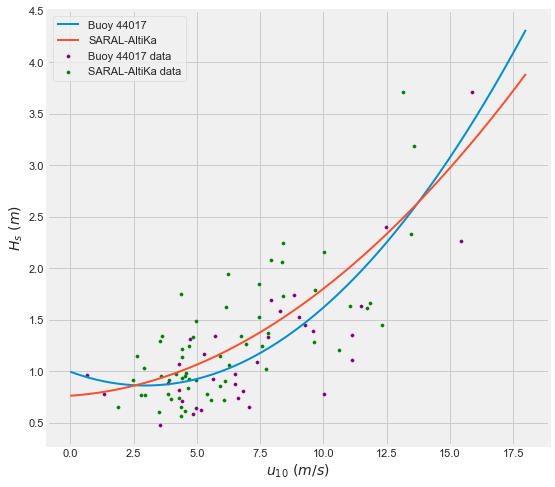

In [847]:
# plot time series of wave height and save figure
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(df5['Buoy 44017 U10'],df5['Buoy 44017 Wave Height'],s=10,color='purple', label='Buoy 44017 data')
ax.scatter(xx, yy, s=10, color='green', label='SARAL-AltiKa data')
ax.plot(xfit, yfit, linewidth=2, label='Buoy 44017')
ax.plot(xxfit, yyfit, linewidth=2, label="SARAL-AltiKa")
plt.xlabel('$u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('$H_{s} \ (m)$', fontsize=14)

#ax.set(xlabel="$u_{10} \ (m/s)$",
 #      ylabel="Significant Wave Height (m)")
ax.legend(loc='best')

## 15 km Radius

In [4]:
final1.index = pd.to_datetime(final1.index)

In [152]:
df = final1.iloc[:,[0,1,3,4]]
#df1.reset_index(inplace=True)
#df1.drop('index', 1, inplace=True)
df = df.resample('D').mean()
df = df.dropna()
len(df)

31

In [153]:
x = df['Buoy 44017 U10']
y = df['Buoy 44017 Wave Height']

xx = df['Cryosat 2 Wind Speed']
yy = df['Cryosat 2 Wave Height']

In [154]:
est = sm.OLS(x, xx)
est2 = est.fit()
est2.conf_int(alpha=0.05, cols=None)

,0,1
Cryosat 2 Wind Speed,0.880783,1.03557


In [155]:
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], xx)

x1fit = np.linspace(0, 17, 34)
y1fit= model.predict(x1fit[:, np.newaxis])

print("Model slope:", model.coef_)
print("Model Intercept:", model.intercept_)

Model slope: [1.06007129]
Model Intercept: -0.5798129315529064


In [156]:
a = model.coef_
b = model.intercept_

In [157]:
scores_mean = list()
scores_std = list()

scores = cross_validate(model, x[:, np.newaxis], xx, scoring=['r2', 'neg_root_mean_squared_error'], cv=4)

rsquared = np.mean(scores['test_r2'])
rmse = -np.mean(scores['test_neg_root_mean_squared_error'])
rmsee = np.std(scores['test_neg_root_mean_squared_error'])

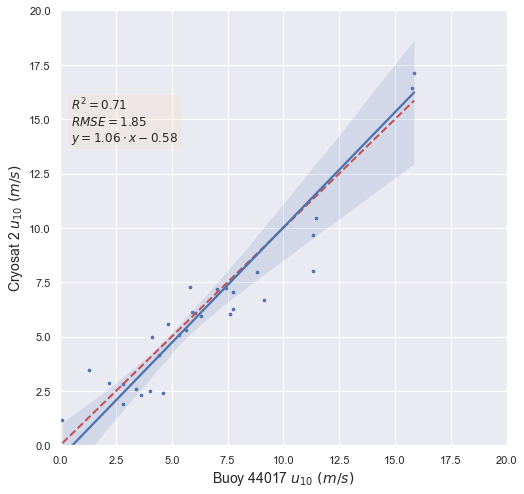

In [158]:
fig, ax = plt.subplots(figsize=(8, 8))
#plt.scatter(x, xx, s=10, color='k', label='data')
#plt.plot(x1fit, y1fit, linewidth=2, label='fitted')
plt.plot([np.amin(x), np.amax(x)], [np.amin(x), np.amax(x)], linestyle='--', linewidth=2, color='r', label='$y=x$')

sns.regplot(x,xx,ci=95,color='b',scatter_kws={'s':7,'alpha':1}, label='data')

#ax.fill_between(lower_ci, upper_ci, alpha=0.1)

plt.xlabel('Buoy 44017 $u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('Cryosat 2 $u_{10} \ (m/s)$', fontsize=14)

plt.xlim(0,20)
plt.ylim(0,20)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)

textstr = '\n'.join((r'$R^2=%.2f$' % (rsquared, ), r'$RMSE=%.2f$' % (rmse, ), 
                     r'$y= %.2f \cdot x %.2f$' % (a,b, )))
                     
#text
ax.text(0.5,14,textstr,fontsize=12,bbox=props)

#ax.legend(loc='best')
plt.savefig('Cryosat2_B44017_wind.png', dpi=300, bbox_inches='tight')

In [159]:
model = LinearRegression(fit_intercept=True)

model.fit(y[:, np.newaxis], yy)

x2fit = np.linspace(0, 4, 1000)
y2fit = model.predict(x2fit[:, np.newaxis])

print("Model slope:", model.coef_)
print("Model Intercept:", model.intercept_)

Model slope: [0.8252479]
Model Intercept: 0.2790698686163422


In [160]:
a = model.coef_
b = model.intercept_

In [161]:
scores_mean = list()
scores_std = list()

scores = cross_validate(model, y[:, np.newaxis], yy, scoring=['r2', 'neg_root_mean_squared_error'], cv=4)

rsquared = np.mean(scores['test_r2'])
rmse = -np.mean(scores['test_neg_root_mean_squared_error'])
rmsee = np.std(scores['test_neg_root_mean_squared_error'])

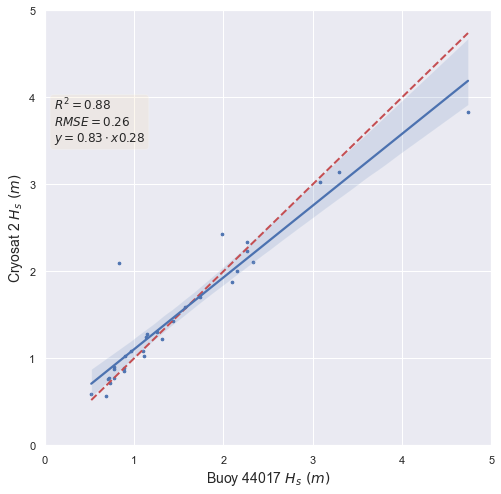

In [163]:
fig, ax = plt.subplots(figsize=(8, 8))
#plt.scatter(y, yy, s=10, color='k', label='data')
#plt.plot(x2fit, y2fit, linewidth=2, label='fitted')
plt.plot([np.amin(y), np.amax(y)], [np.amin(y), np.amax(y)], linestyle='--', linewidth=2, color='r', label='1-1 line')

sns.regplot(y,yy,ci=95,color='b',scatter_kws={'s':7,'alpha':1})

plt.xlabel('Buoy 44017 $H_{s} \ (m)$', fontsize=14)
plt.ylabel('Cryosat 2 $H_{s} \ (m)$', fontsize=14)

plt.xlim(0,5)
plt.ylim(0,5)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)

textstr = '\n'.join((r'$R^2=%.2f$' % (rsquared, ), r'$RMSE=%.2f$' % (rmse, ), 
                     r'$y= %.2f \cdot x %.2f$' % (a,b, )))
                     
#text
ax.text(0.1,3.5,textstr,fontsize=12,bbox=props)
#ax.legend(loc='best')

plt.savefig('Cryosat2_B44017_wave.png', dpi=300, bbox_inches='tight')

In [164]:
model = LinearRegression(fit_intercept=False)

model.fit(x[:, np.newaxis], y)
xfit = np.linspace(0, 18, 1000)

poly_model = make_pipeline(PolynomialFeatures(2), model)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

In [165]:
# model / line coefficients
poly_model.steps[1][1].coef_

array([ 1.1965914 , -0.0801721 ,  0.01345958])

In [166]:
a = poly_model.steps[1][1].coef_[0]
b = poly_model.steps[1][1].coef_[1]
c = poly_model.steps[1][1].coef_[2]

In [167]:
scores_mean = list()
scores_std = list()

scores = cross_validate(poly_model, x[:, np.newaxis], y, scoring=['r2', 'neg_root_mean_squared_error'], cv=7)

rsquared = -np.mean(scores['test_r2'])
rmse = -np.mean(scores['test_neg_root_mean_squared_error'])
rmsee = np.std(scores['test_neg_root_mean_squared_error'])

Text(0.6, 4.3, '$R^2=0.71$\n$RMSE=0.73 \\pm 0.27$\n$y= 0.01x^{2} -0.08x + 1.20$')

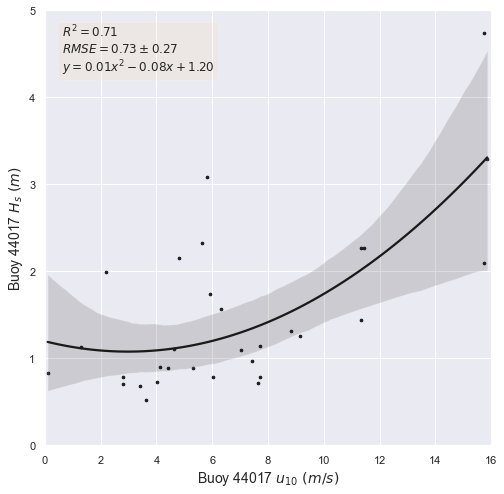

In [168]:
# plot time series of wave height and save figure
fig, ax = plt.subplots(figsize=(8, 8))

#ax.scatter(x, y, s=10, color='green', label='SARAL-AltiKa data')

#ax.plot(xxfit, yyfit, linewidth=2, label="SARAL-AltiKa")
sns.regplot(x,y,order=2,ci=95,color='k',scatter_kws={'s':7,'alpha':1})

plt.xlim(0,16)
plt.ylim(0,5)

plt.xlabel('Buoy 44017 $u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('Buoy 44017 $H_{s} \ (m)$', fontsize=14)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)

textstr = '\n'.join((r'$R^2=%.2f$' % (rsquared, ), r'$RMSE=%.2f \pm %.2f$' % (rmse, rmsee, ), 
                     r'$y= %.2fx^{2} %.2fx + %.2f$' % (c,b,a, )))
                     
#text
ax.text(0.6,4.3,textstr,fontsize=12,bbox=props)

In [169]:
model = LinearRegression(fit_intercept=False)

model.fit(xx[:, np.newaxis], yy)
xxfit = np.linspace(0, 18, 1000)

poly_model1 = make_pipeline(PolynomialFeatures(2), model)

poly_model1.fit(xx[:, np.newaxis], yy)
yyfit = poly_model1.predict(xxfit[:, np.newaxis])

In [170]:
poly_model1.steps[1][1].coef_

array([ 0.58576605,  0.17086514, -0.00318625])

In [171]:
a = poly_model1.steps[1][1].coef_[0]
b = poly_model1.steps[1][1].coef_[1]
c = poly_model1.steps[1][1].coef_[2]

In [172]:
scores_mean = list()
scores_std = list()

scores = cross_validate(poly_model1, xx[:, np.newaxis], yy, scoring=['r2', 'neg_root_mean_squared_error'], cv=5)

rsquared = -np.mean(scores['test_r2'])
rmse = -np.mean(scores['test_neg_root_mean_squared_error'])
rmsee = np.std(scores['test_neg_root_mean_squared_error'])

(0.0, 5.0)

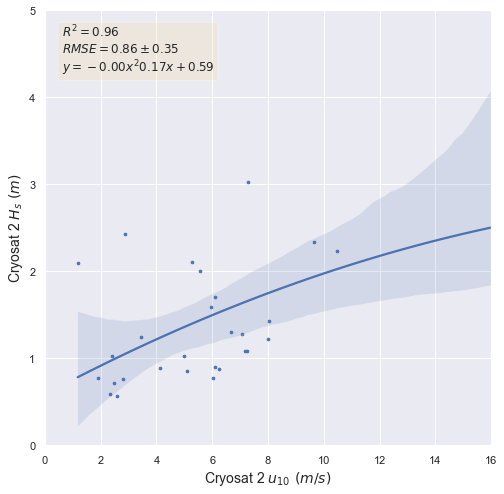

In [173]:
# plot time series of wave height and save figure
fig, ax = plt.subplots(figsize=(8, 8))

#ax.scatter(xx, yy, s=10, color='green', label='SARAL-AltiKa data')

#ax.plot(xxfit, yyfit, linewidth=2, label="SARAL-AltiKa")
sns.regplot(xx,yy,order=2,ci=95,color='b',scatter_kws={'s':7,'alpha':1})

plt.xlabel('Cryosat 2 $u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('Cryosat 2 $H_{s} \ (m)$', fontsize=14)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)

textstr = '\n'.join((r'$R^2=%.2f$' % (rsquared, ), r'$RMSE=%.2f \pm %.2f$' % (rmse, rmsee, ), 
                     r'$y= %.2fx^{2} %.2fx + %.2f$' % (c,b,a, )))
                     
#text
ax.text(0.6,4.3,textstr,fontsize=12,bbox=props)

plt.xlim(0,16)
plt.ylim(0,5)
#ax.set(xlabel="$u_{10} \ (m/s)$",
 #      ylabel="Significant Wave Height (m)")
#ax.legend(loc='best')
#extra = plt.Rectangle((2, 2), 1, 1, facecolor="black", alpha=0, fill=False)
#ax.legend([extra], [(r'$R^2={:.2f}$' + '\n' + r'$RMSE={:.2f} \pm {:.2f}$').format(-np.mean(scores['test_r2']),
                                                     # -np.mean(scores['test_neg_root_mean_squared_error']),
                                                     # np.std(scores['test_neg_root_mean_squared_error']))], loc='upper left')

In [174]:
xt = np.linspace(0, 18, 1000)
yt = 0.02*xt*xt

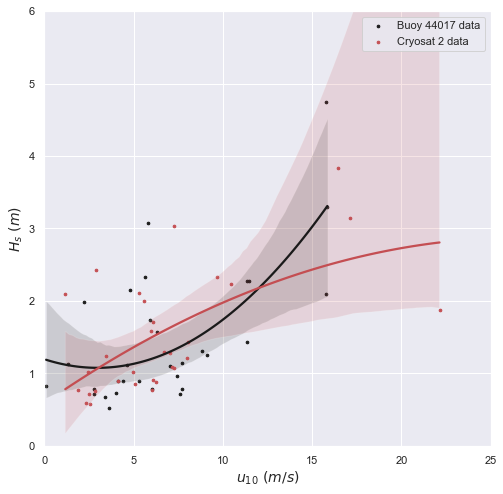

In [175]:
# plot time series of wave height and save figure
fig, ax = plt.subplots(figsize=(8, 8))
#ax.scatter(df['Buoy 44017 U10'],df['Buoy 44017 Wave Height'],s=10,color='purple', label='Buoy 44017 data')
#ax.scatter(xx, yy, s=10, color='green', label='SARAL-AltiKa data')
#ax.plot(xfit, yfit, linewidth=2, label='Buoy 44017')
#ax.plot(xxfit, yyfit, linewidth=2, label="SARAL-AltiKa")
sns.regplot(x,y,order=2,ci=95,color='k',label='Buoy 44017 data',scatter_kws={'s':7,'alpha':1})
sns.regplot(xx,yy,order=2,ci=95,color='r',label='Cryosat 2 data',scatter_kws={'s':7,'alpha':1})
#ax.plot(xt, yt, linewidth=2, label='$H_{s}=0.02 \cdot u_{10n}^{2}$')
plt.xlabel('$u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('$H_{s} \ (m)$', fontsize=14)


plt.xlim(0,25)
plt.ylim(0,6)
#ax.set(xlabel="$u_{10} \ (m/s)$",
 #      ylabel="Significant Wave Height (m)")
ax.legend(loc='best')

plt.savefig('Cryosat2_B44017_wind_wave.png', dpi=300, bbox_inches='tight')